In [1]:
import numpy as np
import mxnet as mx
from PIL import Image
import tvm
from tvm import relay

In [2]:
model = mx.gluon.model_zoo.vision.resnet18_v2(pretrained=True)
len(model.features), model.output

(13, Dense(512 -> 1000, linear))

In [3]:
with open('./data/imagenet1k_labels.txt') as f:
    labels = eval(f.read())

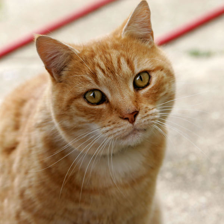

In [4]:
image = Image.open('./data/cat.jpg').resize((224, 224))
image

In [5]:
def image_preprocessing(image):
    image = np.array(image) - np.array([123., 117., 104.])
    image /= np.array([58.395, 57.12, 57.375])
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :]
    return image.astype('float32')

x = image_preprocessing(image)
x.shape

(1, 3, 224, 224)

To compile a model, we first express the MXNet model in Relay IR

#### What is Relay

Relay is a high-level intermediate representation (IR) in the TVM framework.

Relax is a high-level graph abstraction in Apache TVM that represents and optimizes machine learning models. Here are its key characteristics:

- Core Features
- High-Level Representation:
- Represents entire neural network executions
- Applies high-level operators to tensors
- Supports passing tensors between functions
- Can invoke lower-level TensorIR functions

https://tvm.apache.org/docs/reference/api/python/relay/index.html

In [6]:
relay_mod, relay_params = relay.frontend.from_mxnet(model, {'data': x.shape})
type(relay_mod), type(relay_params)

(tvm.ir.module.IRModule, dict)

In [7]:
relay_params

{'resnetv20_batchnorm0_gamma': <tvm.nd.NDArray shape=(3,), cpu(0)>
 array([1., 1., 1.], dtype=float32),
 'resnetv20_batchnorm0_beta': <tvm.nd.NDArray shape=(3,), cpu(0)>
 array([0., 0., 0.], dtype=float32),
 'resnetv20_batchnorm0_running_mean': <tvm.nd.NDArray shape=(3,), cpu(0)>
 array([-0.0635569 , -0.06679017, -0.06803726], dtype=float32),
 'resnetv20_batchnorm0_running_var': <tvm.nd.NDArray shape=(3,), cpu(0)>
 array([1.5097775, 1.503464 , 1.5640337], dtype=float32),
 'resnetv20_conv0_weight': <tvm.nd.NDArray shape=(64, 3, 7, 7), cpu(0)>
 array([[[[-1.64019989e-16, -1.64107318e-15,  1.15900094e-14, ...,
            6.13736823e-15,  9.31420553e-15, -4.96812310e-15],
          [-5.24587960e-15, -6.12600231e-15,  2.52703958e-15, ...,
           -8.80555886e-15, -9.94531707e-15,  3.19777765e-15],
          [ 6.95685058e-15,  1.30257726e-14, -9.37785412e-15, ...,
           -1.28336622e-14, -1.03294219e-14,  2.46130834e-15],
          ...,
          [ 1.74203032e-14, -1.88471827e-14, -2

In [8]:
target = 'llvm'
with relay.build_config(opt_level = 3):
    # Compile the IR Module to target
    graph, mod, params = relay.build(relay_mod, target, params=relay_params)

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.
/var/folders/kf/ncvnc9514k361kxbc0yn9_1w0000gn/T/ipykernel_38067/2981885152.py:4: DeprecationWarning: legacy graph executor behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_executor.GraphModule for the  new recommended usage.
  graph, mod, params = relay.build(relay_mod, target, params=relay_params)


In [9]:
type(graph), type(mod), type(params)

(str, tvm.runtime.module.Module, dict)

In [12]:
ctx = tvm.device(target)
rt = tvm.contrib.graph_executor.create(graph, mod, ctx)
rt.set_input(**params)
rt.run(data=tvm.nd.array(x))
scores = rt.get_output(0).asnumpy()[0]
scores.shape

(1000,)

In [15]:
a = np.argsort(scores)[-1:-5:-1]
labels[a[0]], labels[a[1]], labels[a[2]], labels[a[3]]

('tiger cat', 'Egyptian cat', 'tabby, tabby cat', 'bucket, pail')